## LECTURE 4: ML MODELS

In this lecture we are going to build upon the knowledge of last week. In addition to this notebook there are a few slides that explain the various ML models slighly deeper. 

This week you will learn:
* How to set-up a start-to-end data model.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## DATA PIPELINE

To illustrate the use of data pipelines, we are going to generate data using the function below. The task will be a classification task and will contain both numerical and categorical features.

In [3]:
from secrets import choice


def generate_dataset(n_samples: int=1000, n_features: int=6, flip_y: float=0.2):
    """
    Function to generate data
    """
    random.seed(123)
    
    X, y = make_classification(
        n_samples=n_samples, n_features=n_features-1,
        n_classes=3, n_informative=3, flip_y=flip_y
        )

    # convert from numpy to pandas
    X = pd.DataFrame(X)
    y = pd.Series(y)

    # pick a few features at random to convert to categorical
    cat_cols = np.sort(
        np.random.choice(
            X.columns, size=int(len(X.columns)/3), replace=False
        )
    )

    # conver numerical features to categorical
    X.iloc[:, cat_cols] = X.iloc[:, cat_cols].apply(
        lambda col: np.round((col - min(col)) / (max(col) - min(col)) * 3, 0),
        axis=0
    )

    X.iloc[:, cat_cols] = X.iloc[:, cat_cols].values.astype(str)

    # convert column names to indicate whether numerical/categorical
    cat_rename_mapper = {
        column: 'categorical_' + str(index) for index, column in enumerate(cat_cols)
        }
    num_rename_mapper = {
        column: 'numerical_' + str(index) for index, column in enumerate(
            X.columns.symmetric_difference(cat_cols))
        }
    rename_maper = {**cat_rename_mapper, **num_rename_mapper}
    X.rename(columns=rename_maper, inplace=True)

    # split data in train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = generate_dataset()

For our data pipeline, we need to know which features are categorical or numerical. Both types of variables require different steps.

In [4]:
categorical_cols = [column for column in X_train.columns if 'categorical' in column]
numerical_cols = [column for column in X_train.columns if 'numerical' in column]

In [5]:
# create ColumnTransformer, and pass the column names to transform in each step

def make_pipeline(categorical_cols=[], numerical_cols=[], classifier=LogisticRegression()):
    preprocessor = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
            ('scale', StandardScaler(), numerical_cols)
        ]
    )

    clf = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )

    return clf


Now that we have defined our pipeline, let's see how different models will perform on our generated data. We define the models that we want to test below.

In [6]:
models_to_run = [
    LogisticRegression(multi_class='multinomial'),
    RandomForestClassifier(max_depth=2),
    RandomForestClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10),
    RandomForestClassifier(max_depth=20),
    RandomForestClassifier(max_depth=80),
    MLPClassifier(hidden_layer_sizes=2),
    MLPClassifier(hidden_layer_sizes=6),
    MLPClassifier(hidden_layer_sizes=10),
    MLPClassifier(hidden_layer_sizes=20),
    MLPClassifier(hidden_layer_sizes=40)
    ]

The standard classification metric to evaluate our models is the Accuracy. This metric works ok in generic situations, but might not be the best in cases where the distribution of the target, y, is not even. This situation is normally referred to as **unbalanced**.

We will quickly assess our target distribution before we continue.

([<matplotlib.patches.Wedge at 0x157d31940>,
 [Text(0.5499999702695115, 0.9526279613277875, '0'),
  Text(-1.0997587501256068, -0.02303674287227772, '1'),
  Text(0.5698297502461536, -0.9409006619906304, '2')])

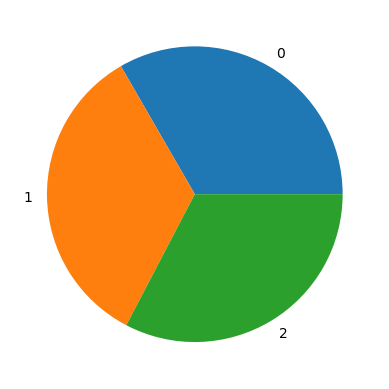

In [7]:
plt.pie(np.bincount(y_train) / len(y_train), labels=np.unique(y_train))

The distribution is approximately even, so we continue. We will now run the models on our data, store the clasification results (the Accuracy!) and show them using a pandas dataframe.

In [8]:
results = {}
for model in models_to_run:

    # create instance of the class, feed the model to be tested
    clf = make_pipeline(categorical_cols, numerical_cols, model)
    clf.fit(X_train, y_train)

    # store results in a dictionary 
    results[str(model)] = clf.score(X_test, y_test)
pd.DataFrame.from_dict(results, orient='index', columns=['score'])

/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

,score
LogisticRegression(multi_class='multinomial'),0.668
RandomForestClassifier(max_depth=2),0.696
RandomForestClassifier(max_depth=5),0.732
RandomForestClassifier(max_depth=10),0.764
RandomForestClassifier(max_depth=20),0.724
RandomForestClassifier(max_depth=80),0.736
MLPClassifier(hidden_layer_sizes=2),0.632
MLPClassifier(hidden_layer_sizes=6),0.668
MLPClassifier(hidden_layer_sizes=10),0.672
MLPClassifier(hidden_layer_sizes=20),0.744


There are big differences between the performances, but the random forest and the neural network seem to be the big winners. Let's dive in a little bit. 

### LOGISTIC REGRESSION
**Advantages**: interpretable results and should be used in cases where you want to understand relationships.

**Disadvantages**: often not able to capture complex/relationships and doesnt work well out of the box if non-linearities are present.

### RANDOM FOREST
**Advantages**: works very well out of the box. Is resilient against overfitting and is able to capture complex (non-linear) relationships. Almost no data-preprocessing is needed!

**Disadvantages**: there are many hyperparamers to tune, not as interpretable as logistic regression.

### Neural Network
**Advantages**: can model any function. Can lead to very high results, IF tuned properly. 

**Disadvantages**: very easy to overfit, designing a model can take a long time, almost no interpretability. 

## WINE DATASET

So, let's see how well our pipeline will perform on some real-world examples. Our first stop is the famous 'wine' dataset, where we ought to predict the quality of wines given several features.

In [9]:
wine = pd.read_csv("winequality-red.csv")

In [11]:
y_wine = wine['quality']
X_wine = wine.drop(['quality'], axis=1)

This dataset is actually a regression problem, but we will change it into a classification problem by grouping the target. We will create two groups: 'medium' with all rating up to and including 6, and 'excellent' containg all ratings from 7.

In [12]:
# Create Classification version of target variable
y_wine = pd.Series([1 if x >= 7 else 0 for x in y_wine])

In [13]:
y_wine = y_wine.replace({0: 'medium', 1: 'excellent'})

So what do our features look like?

In [38]:
X_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


Do we have any categorical feature hiding in our dataset that we would want to one-hot-encode with our pipeline?

In [39]:
X_wine.nunique()

fixed acidity            96
volatile acidity        143
citric acid              80
residual sugar           91
chlorides               153
free sulfur dioxide      60
total sulfur dioxide    144
density                 436
pH                       89
sulphates                96
alcohol                  65
dtype: int64

In principal, I would say its ok to treat the features as numeric.

The distribution of the labels will give use some indications how we should treat this problem.

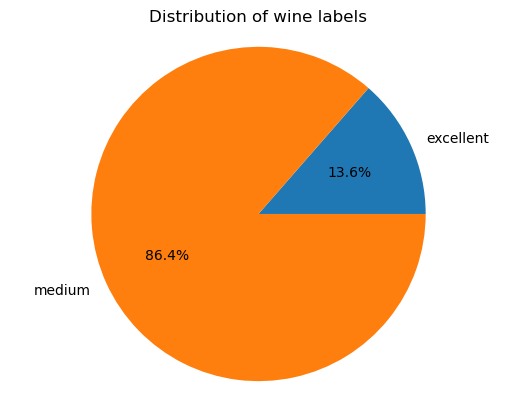

In [14]:
labels_wine, counts_wine = np.unique(y_wine, return_counts=True)
plt.pie(counts_wine / len(y_wine), labels=labels_wine, autopct='%1.1f%%')
plt.title('Distribution of wine labels')
plt.axis('equal')
plt.show()


The distribution of the labels is a off. It means that we can get 86% accuracy by always predicting 'mediun'. Therefor we need a metric that somehow corrects for this. We find our corrected metric in someone called the 'F1 score'. We will also try to 'fix' the class imbalance by adding a parameter to our pipeline.

In [16]:
X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(X_wine, y_wine, test_size=.50, random_state=15)

In [17]:
categorical_cols = []
numerical_cols = X_train_wine.columns

In [18]:
results = {}
for model in models_to_run:

    # create instance of the class, feed the model to be tested
    clf = make_pipeline(categorical_cols, numerical_cols, model)
    clf.fit(X_train_wine, y_train_wine)

    # store results in a dictionary 
    results[str(model)] = clf.score(X_test_wine, y_test_wine)
pd.DataFrame.from_dict(results, orient='index', columns=['score'])

/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

,score
LogisticRegression(multi_class='multinomial'),0.87750
RandomForestClassifier(max_depth=2),0.87250
RandomForestClassifier(max_depth=5),0.90000
RandomForestClassifier(max_depth=10),0.90375
RandomForestClassifier(max_depth=20),0.91125
RandomForestClassifier(max_depth=80),0.90625
MLPClassifier(hidden_layer_sizes=2),0.86625
MLPClassifier(hidden_layer_sizes=6),0.87625
MLPClassifier(hidden_layer_sizes=10),0.88125
MLPClassifier(hidden_layer_sizes=20),0.87500


In [19]:
from sklearn.metrics import f1_score

results = {}
for model in models_to_run:

    # create instance of the class, feed the model to be tested
    clf = make_pipeline(categorical_cols, numerical_cols, model)
    clf.fit(X_train_wine, y_train_wine)

    # store results in a dictionary 
    results[str(model)] = f1_score(y_test_wine, clf.predict(X_test_wine), average="weighted")
pd.DataFrame.from_dict(results, orient='index', columns=['score'])


/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) 

,score
LogisticRegression(multi_class='multinomial'),0.868228
RandomForestClassifier(max_depth=2),0.816110
RandomForestClassifier(max_depth=5),0.887810
RandomForestClassifier(max_depth=10),0.904225
RandomForestClassifier(max_depth=20),0.906961
RandomForestClassifier(max_depth=80),0.900499
MLPClassifier(hidden_layer_sizes=2),0.822623
MLPClassifier(hidden_layer_sizes=6),0.866825
MLPClassifier(hidden_layer_sizes=10),0.871900
MLPClassifier(hidden_layer_sizes=20),0.880167


## IN PRACTICE: MNIST DATASET

In [20]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [21]:
from sklearn.datasets import load_digits

In [22]:
(X_digits_train, y_digits_train), (X_digits_test, y_digits_test) = load_data()

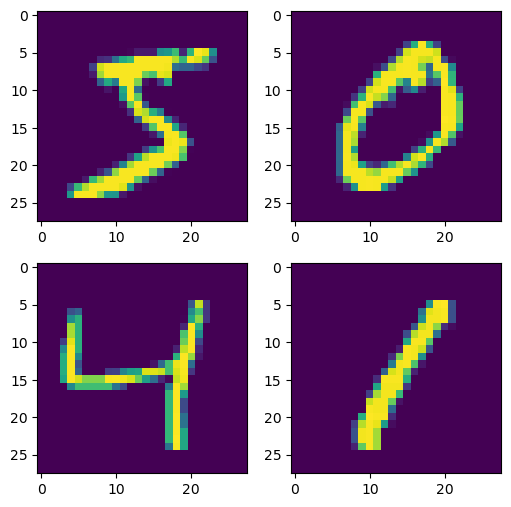

In [23]:
plt.figure(figsize=(6,6)) # specifying the overall grid size

for i in range(4):
    plt.subplot(2,2,i+1)    # the number of images in the grid is 5*5 (25)
    plt.imshow(X_digits_train[i])

plt.show()

In [24]:
inp_shape = X_digits_train.shape[1:]

In [25]:
# defining the model
def create_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inp_shape + (1,)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(48, (3, 3), activation='relu'))
    model.add(MaxPool2D((2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
nn_clasifier = KerasClassifier(build_fn=create_model, verbose=0)

/var/folders/zq/9lh8_0ds0611mg3hwzksgm0r0000gn/T/ipykernel_36574/803054884.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  nn_clasifier = KerasClassifier(build_fn=create_model, verbose=0)


In [33]:
models_to_run = [
    LogisticRegression(multi_class='multinomial'),
    RandomForestClassifier(max_depth=20),
    MLPClassifier(hidden_layer_sizes=20),
    nn_clasifier
    ]

In [34]:
from sklearn.base import BaseEstimator, TransformerMixin

class mean_over_input_dimension(BaseEstimator, TransformerMixin):
    def __init__(self, dimension=2):
        self.dimension=dimension

    def transform(self, img):
        return np.mean(img, axis=self.dimension)


In [35]:
from sklearn.preprocessing import FunctionTransformer

In [36]:
# create ColumnTransformer, and pass the column names to transform in each step

def mean_over_second_image_dimension(img):
    return np.mean(img, axis=2)

transformer = FunctionTransformer(mean_over_second_image_dimension)


def make_pipeline_mnist(classifier=LogisticRegression()):

    clf = Pipeline(
        steps=[
            ('classifier', classifier)
        ]
    )

    if not isinstance(classifier, KerasClassifier):
        clf.steps.insert(0, ['estimator', transformer]) #insert as first step


    return clf


In [37]:
results = {}
for model in models_to_run:
    # create instance of the class, feed the model to be tested
    clf = make_pipeline_mnist(model)
    clf.fit(X_digits_train, y_digits_train)

    # store results in a dictionary 
    results[str(model)] = clf.score(X_digits_test, y_digits_test)
pd.DataFrame.from_dict(results, orient='index', columns=['score'])

/usr/local/Caskroom/miniconda/base/envs/lecture03/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,score
LogisticRegression(multi_class='multinomial'),0.6945
RandomForestClassifier(max_depth=20),0.8535
MLPClassifier(hidden_layer_sizes=20),0.8460
<keras.wrappers.scikit_learn.KerasClassifier object at 0x17e395400>,0.9804
